# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [82]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [83]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [84]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [85]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./moviereviews_train.tsv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [204]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
ols = Ridge(alpha=1)
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 5289, 'TN': 4626, 'FP': 5370, 'FN': 4715, 'Accuracy': 0.49575, 'Precision': 0.49620039403321137, 'Recall': 0.5286885245901639, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [205]:
from sklearn import linear_model
svm = Ridge(alpha=1)
svm = linear_model.SGDClassifier()

svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [206]:
from sklearn import linear_model
lgs = Ridge(alpha=1)
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [207]:
from sklearn.naive_bayes import MultinomialNB
nbs = Ridge(alpha=1)
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 9603, 'TN': 9830, 'FP': 166, 'FN': 401, 'Accuracy': 0.97165, 'Precision': 0.9830074726174634, 'Recall': 0.9599160335865654, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [208]:
from sklearn import linear_model
prc = Ridge(alpha=1)
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [209]:
from sklearn import linear_model
rdg = Ridge(alpha=1)
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [210]:
from sklearn.ensemble import RandomForestClassifier
rdf = Ridge(alpha=1)
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 7999, 'TN': 7480, 'FP': 2516, 'FN': 2005, 'Accuracy': 0.77395, 'Precision': 0.7607227769852591, 'Recall': 0.7995801679328268, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

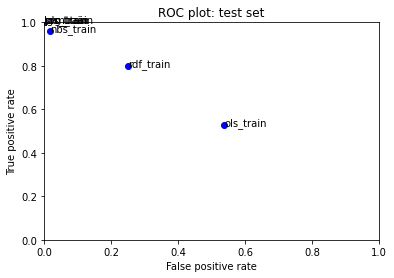

In [211]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [212]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [213]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
76
The Fiendish Plot of Dr. Fu Manchu (1980). This is hands down the worst film I've ever seen. What a sad way for a great comedian to go out.
* * * * * * * * * 
143
If I hadn't read his name on the DVD cover, I never would have suspected that this rather gushy and old fashioned musical was made by a man so closely associated with the French New Wave. In fact, the film is so far from that, that I wonder if back in the 50s and 60s, New Wave auteurs would have absolutely hated this type of film--it's so...so...unreal. And, it seems to have little to do with so many of his previous films. This isn't necessarily a bad thing--just a very surprising thing.<br /><br />What I also found a bit surprising was the amount of praise some of the reviewers gave this film--especially when there are so many better French musicals out there. The songs in this film were simply not particularly interesting and the characters all seemed so bland and stereotypical. If I had to s

3483
I don't know what that other guy was thinking. The fact that this movie was independently made makes it no less terrible. You can be as big a believer as you want... the majority of this film is mindless drivel. I feel i have been insulted by having to watch the first 40 minutes of it. And that alone was no small feat. Not only is the acting terrible, but the plot is never even close to developed. There are countless holes in the story, to the point where you can hardly even call it a story anymore. I've never read the book, so I can't critique on that, but this is the first review that I've written here and it's purpose is solely to save all you viewers out there an hour and a half of your life. I can't remember the last time I couldn't even finish watching a movie. This one really takes the cake.
* * * * * * * * * 
3493
An old intellectual talks about what he considers art in movies. You get your Hitchcock, your Chaplin, your Bergman and some other stuff prior to the 80ies. To d

6525
OK Hollywood is not liberal.<br /><br />Obviously I'm lieing because it is. Im a conservative but the politics i will leave out of my opinion of the movie. This movie was anti bush, anti middle east , anti big oil propaganda but that is not why it was bad.<br /><br />Fist off i will give credit where credit is due. i saw this film opening night because i happen to like these kinds of films and am a political science major in collage. The cinematography was excellent and the acting was as far as i could tell very good.<br /><br />The plot was impossible for me to decode however. I have been tested and have an IQ of 138 but no matter how hard i tried there was no way i could piece together the story line of the movie and what characters where doing what.<br /><br />The story and scene sequence was totally incoherent and poorly organized.<br /><br />Unless this is one of those movies that is meant to be watch many times to get the full depth pf the story, which it very well may be, i

9695
Yep, the topic is a straight quote from the movie and I think it's pretty accurate. I was so bored to dead with this pointless effort. All the flashes etc. making no sense after first 20 minutes is just bad film making + If you are epileptic, you would have died at least five times already. Of course all the David Lynch fans would raise a flag for this kind of turkey to be \the best film ever made\" because it doesn't make any sense AND when it doesn't make any sense it's got to be art, and art movie is always good. Right? I say WRONG. This kind of artificial art grab is just a pathetic way to try to show that you're a good film maker. Anthony Hopkins as a excellent actor should just stay acting."
* * * * * * * * * 
9705
I will probably always go to see a Woody Alleb movie, as one never knows when he just might make a real return to his past greatness. Just one or two great moments or lines could make it worthwhile. sadly however this film just does'nt make it on any score. Saying

12999
Why would anyone want to see this?! If this was a film posted on YouTube by a teenager, I might have applauded the teen in doing so much with his mommy's video camera. I might have also congratulated his family and friends for doing a good job acting. Sadly, it was made by a very experienced film maker and these were, apparently, professional actors--making this a very, very sad film. Sad...and very pathetic, actually. As I said, it has a definite made directly to video look about it. It also has narration and acting that just scream \unprofessionals\"--how could this be?! The film is filled with lots of corpses and blood. Normally this would turn me off completely, as I hate ultra-violent films and don't like seeing all that gore. However, given that none of it is that realistic, it's bearable. However, I should warn you that there are a few scenes that are still pretty disturbing. For example, the scene with the kid throwing a radio into a lady's tub and watching her naked and 

16005
I just watched this movie last night, and I HAD to put a warning out for anybody else considering to see this film. In a word - don't. I seriously feel like this is something that a screenwriting student would have written in a Quentin Tarantino/Eddie Murphy phase, i.e. every other word was a curse word. I don't have a problem with profuse cursing, as in \Good Will Hunting\", provided it helps to delve more into the characters. In this case it was just hollow banter with the attempt to draw an occassional *gasp* or laughter from the audience. The three lead characters are all their own unique stereotype, the wall street jerk, the coffee house jerk, and the \"I'm-Not-Gay-Just-In-Touch-With-My-Feminine-Side\" slightly-less-of-a-jerk. You just don't give a damn about any of them! They are all shallow, unredemable losers who you WANT to see lose. For those who dare, this film does have a couple funny moments, the very beginning, and the very end. The toilet/vibrator scene is funny in

18908
****Don't read this review if you want the shocking conclusion of \The Crater Lake Monster\" to be a total surprise****<br /><br />A claymation plesiosaur rises from the depths of Crater Lake to wreak havoc on a group of local rednecks, not to mention your fast forward button. To call \"The Crater Lake Monster\" amateurish is to overstate the obvious. If you aren't a fan of low budget drive-in films, you probably wouldn't be looking here in the first place.<br /><br />The problem with the movie is that when there's no monster action going on, it really sucks and goes nowhere. The script is very Ed Wood-ish, in that it's utterly contrived in the way it sets up the main action sequences. Nothing is too outlandish for \"The Crater Lake Monster\". It explains its dinosaur by having a meteor crash into Crater Lake, 'superheating' the water to the point where it incubates a dinosaur egg that has apparently been resting at the bottom of the lake for millennia. Even if we could accept th

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [214]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1355, 'TN': 1075, 'FP': 1429, 'FN': 1141, 'Accuracy': 0.486, 'Precision': 0.48670977011494254, 'Recall': 0.5428685897435898, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [215]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2071, 'TN': 2070, 'FP': 434, 'FN': 425, 'Accuracy': 0.8282, 'Precision': 0.8267465069860279, 'Recall': 0.8297275641025641, 'desc': 'svm_test'}


### MODEL: logistic regression

In [216]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2106, 'TN': 2075, 'FP': 429, 'FN': 390, 'Accuracy': 0.8362, 'Precision': 0.8307692307692308, 'Recall': 0.84375, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [217]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1824, 'TN': 1858, 'FP': 646, 'FN': 672, 'Accuracy': 0.7364, 'Precision': 0.7384615384615385, 'Recall': 0.7307692307692307, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [218]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2099, 'TN': 2088, 'FP': 416, 'FN': 397, 'Accuracy': 0.8374, 'Precision': 0.8345924453280318, 'Recall': 0.8409455128205128, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [219]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2091, 'TN': 2019, 'FP': 485, 'FN': 405, 'Accuracy': 0.822, 'Precision': 0.8117236024844721, 'Recall': 0.8377403846153846, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [220]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1988, 'TN': 1823, 'FP': 681, 'FN': 508, 'Accuracy': 0.7622, 'Precision': 0.7448482577744474, 'Recall': 0.7964743589743589, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

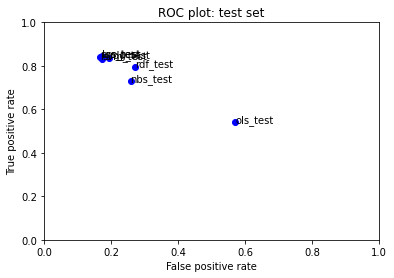

In [221]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation